# Deconvolution Validation

Parameterized notebook to analyze a single dataset in a comparison between Flowdec and DeconvolutionLab2

In [1]:
import tempfile, os, warnings, timeit, math
import pandas as pd
import numpy as np
import papermill as pm
import matplotlib.pyplot as plt
import plotnine as pn
import io as pyio
from skimage import io
from flowdec import data as fd_data
from flowdec import psf as fd_psf
from flowdec.nb import utils as fd_nb_utils
from flowdec import restoration as fd_restoration
from skimage.exposure import rescale_intensity
from skimage.measure import compare_ssim, compare_psnr, compare_nrmse
from scipy.stats import describe
from collections import OrderedDict

c:\users\user\anaconda3\envs\codex\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<hr>
### Parameters

In [2]:
# Default Parameters
n_iter = 25
dl2_path = os.path.join(
    os.path.expanduser('~'), 'repos', 'misc', 'DeconvolutionLab2', 
    'target', 'DeconcolutionLab2_-0.1.0-SNAPSHOT.jar')
downsample_factor = None
crop_slice = None

# Required Parameters
dataset_name = None

In [3]:
# Parameters
crop_slice = "(slice(48, 80), slice(96, 160), slice(192, 320))"
dataset_name = "microtubules"
n_iter = 25


In [4]:
# # Debugging
# dataset_name = 'bars'
# downsample_factor = .25
# crop_slice = '(slice(None), slice(None), slice(None))'

# dataset_name = 'celegans-dapi'
# downsample_factor = None
# crop_slice = '(slice(39, 65), slice(300, 600), slice(300, 600))'

# dataset_name = 'microtubules'
# downsample_factor = None
# crop_slice = '(slice(48, 80), slice(96, 160), slice(192, 320))'

In [5]:
assert dataset_name, 'Must set "dataset_name" parameter'
if crop_slice:
    crop_slice = eval(crop_slice)

<hr>
### Dataset Prep

In [6]:
def prep(acq):
        
    if crop_slice:
        print('Applying crop slices {}'.format(crop_slice))
        acq = acq.apply(lambda v: v[crop_slice])
        
    if downsample_factor:
        print('Downsampling dataset (factor = {})'.format(downsample_factor))
        acq = acq.apply(lambda v: rescale_intensity(v.astype(np.float32), out_range=(-1., 1.)))
        acq = fd_data.downsample_acquisition(acq, downsample_factor)
        
    acq = acq.apply(lambda v: rescale_intensity(v.astype(np.float32), out_range=np.uint16).astype(np.uint16))
    return acq

# Load dataset and run prep function to convert to uint16 and crop/downsample as configured
if dataset_name.startswith('celegans'):
    acq = fd_data.load_celegans_channel(dataset_name.split('-')[1].upper())
else:
    acq = eval('fd_data.load_' + dataset_name + '()')
    
print('Preparing raw dataset with shapes/types:')
print(acq.shape())
print(acq.dtype())
print()
acq = prep(acq)

print('\nPrepared dataset shapes/types:')
print(acq.shape())
print(acq.dtype())

print('\nDataset stats:')
print('\n'.join(map(str, acq.stats().items())))

Preparing raw dataset with shapes/types:

{'data': (128, 256, 512), 'kernel': (128, 256, 512), 'actual': (128, 256, 512)}

{'data': dtype('uint16'), 'kernel': dtype('float32'), 'actual': dtype('float32')}

Applying crop slices (slice(48, 80, None), slice(96, 160, None), slice(192, 320, None))


Prepared dataset shapes/types:

{'data': (32, 64, 128), 'kernel': (32, 64, 128), 'actual': (32, 64, 128)}

{'data': dtype('uint16'), 'kernel': dtype('uint16'), 'actual': dtype('uint16')}


Dataset stats:

('data', DescribeResult(nobs=262144, minmax=(0, 65535), mean=14670.674674987793, variance=51423441.35257336, skewness=0.8527739918299144, kurtosis=0.43615563978270444))
('kernel', DescribeResult(nobs=262144, minmax=(0, 65535), mean=59.25767135620117, variance=207957.22274511572, skewness=67.16837352977302, kurtosis=6283.895013136618))
('actual', DescribeResult(nobs=262144, minmax=(0, 65535), mean=460.5070457458496, variance=11691050.204296833, skewness=8.526765233975361, kurtosis=78.52063772920305))

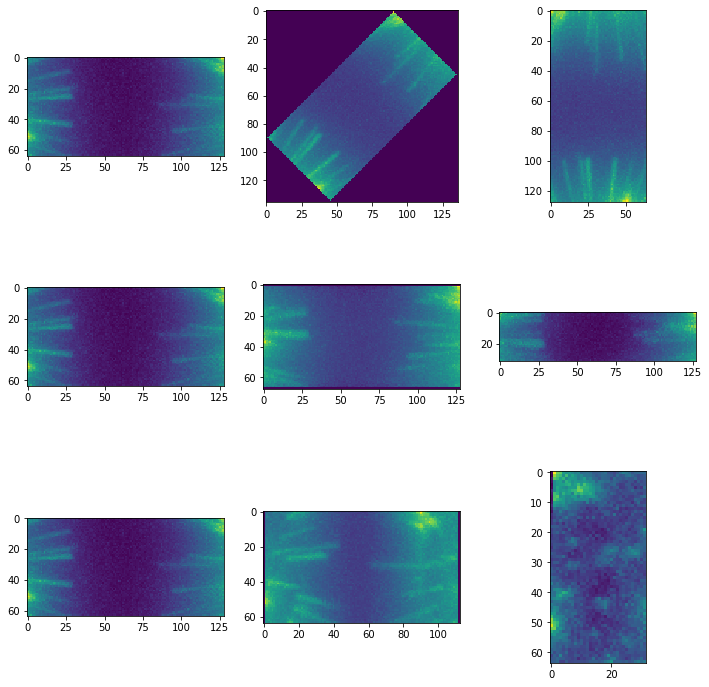

In [7]:
# Visualize various projections/rotations of the volume to be deconvolved
fd_nb_utils.plot_rotations(acq.data)

<hr>
### Run Deconvolution

In [8]:
def to_uint(img):
    tinfo = np.iinfo(np.uint16)
    return img.clip(tinfo.min, tinfo.max).astype(np.uint16)

def run_flowdec(data, kernel, **kwargs):
    algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, **kwargs)
    acq = fd_data.Acquisition(data=data, kernel=kernel)
    img = algo.initialize().run(acq, niter=n_iter).data
    return to_uint(img)
    
def run_dl2(data, kernel, algo='RL {}'.format(n_iter), exargs='-constraint nonnegativity'):
    # Generate temporary files to store image data within
    data_file   = tempfile.mktemp('.tif', 'data-')
    kernel_file = tempfile.mktemp('.tif', 'kernel-')
    output_file = tempfile.mktemp('', 'output-') 

    # Ignore low-contrast image warnings from skimage
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        io.imsave(data_file, acq.data)
        io.imsave(kernel_file, acq.kernel)
    
    # Setup system call to execute DL2 CLI
    dl2_cmd = "java -Xmx32G -cp {jar} DeconvolutionLab2 Run -image file {data}"\
        " -psf file {psf} -algorithm {algo} {exargs} -out stack {output_file} -path {output_path}"\
        .format(
            jar=dl2_path, data=data_file, psf=kernel_file, algo=algo, exargs=exargs,
            output_file=os.path.basename(output_file), output_path=os.path.dirname(output_file)
        )
    !$dl2_cmd
    img = io.imread(output_file + '.tif')
    return to_uint(img)

In [9]:
acq_decon = OrderedDict()

In [10]:
%%capture
# Non-negative constraint
acq_decon[('dl2', 'rl-npad')] = run_dl2(acq.data, acq.kernel)

In [11]:
%%capture
# Power of 2 padding, non-negative constraint
acq_decon[('dl2', 'rl-wpad')] = run_dl2(acq.data, acq.kernel, exargs='-pad E2 E2 1 1 -constraint nonnegativity')

In [12]:
%%capture
# Naive-inverse Filtering
acq_decon[('dl2', 'nif')] = run_dl2(acq.data, acq.kernel, algo='NIF')

In [13]:
%%capture
# Regularized Richardson Lucy
acq_decon[('dl2', 'rltv')] = run_dl2(acq.data, acq.kernel, algo='RLTV 10 0.1')

In [14]:
%%capture
# Regularized Inverse Filtering
acq_decon[('dl2', 'rif')] = run_dl2(acq.data, acq.kernel, algo='RIF 0.001')

In [15]:
%%capture
# Landweber
acq_decon[('dl2', 'lw')] = run_dl2(acq.data, acq.kernel, algo='LW 25 1.0')

In [16]:
# Emulate DeconvolutionLab2 behavior with no padding
acq_decon[('flowdec', 'rl-npad')] = run_flowdec(acq.data, acq.kernel, start_mode='input', pad_mode='none')

# Emulate DeconvolutionLab2 behavior w/ padding noting that paddings must be with 0s rather 
# than reflection of images (DL2 doesn't seem to support anything other than 0 padding)
acq_decon[('flowdec', 'rl-wpad')] = run_flowdec(acq.data, acq.kernel, start_mode='input', pad_mode='log2', 
                                         pad_min=[1,1,1], pad_fill='constant')

# Also include default flowdec settings w/ small minimum padding
acq_decon[('flowdec', 'rl-default')] = run_flowdec(acq.data, acq.kernel, pad_min=[1,1,1])

In [17]:
# Ensure that all results are of the same type
unique_types = {k: img.dtype for k, img in acq_decon.items()}
assert len(np.unique(unique_types.values())) == 1, \
    'Results have differing data types; Data type by result: {}'.format(unique_types)
print('Data type of all results:', list(unique_types.values())[0])

Data type of all results:

uint16

<hr>

### Visualize Results

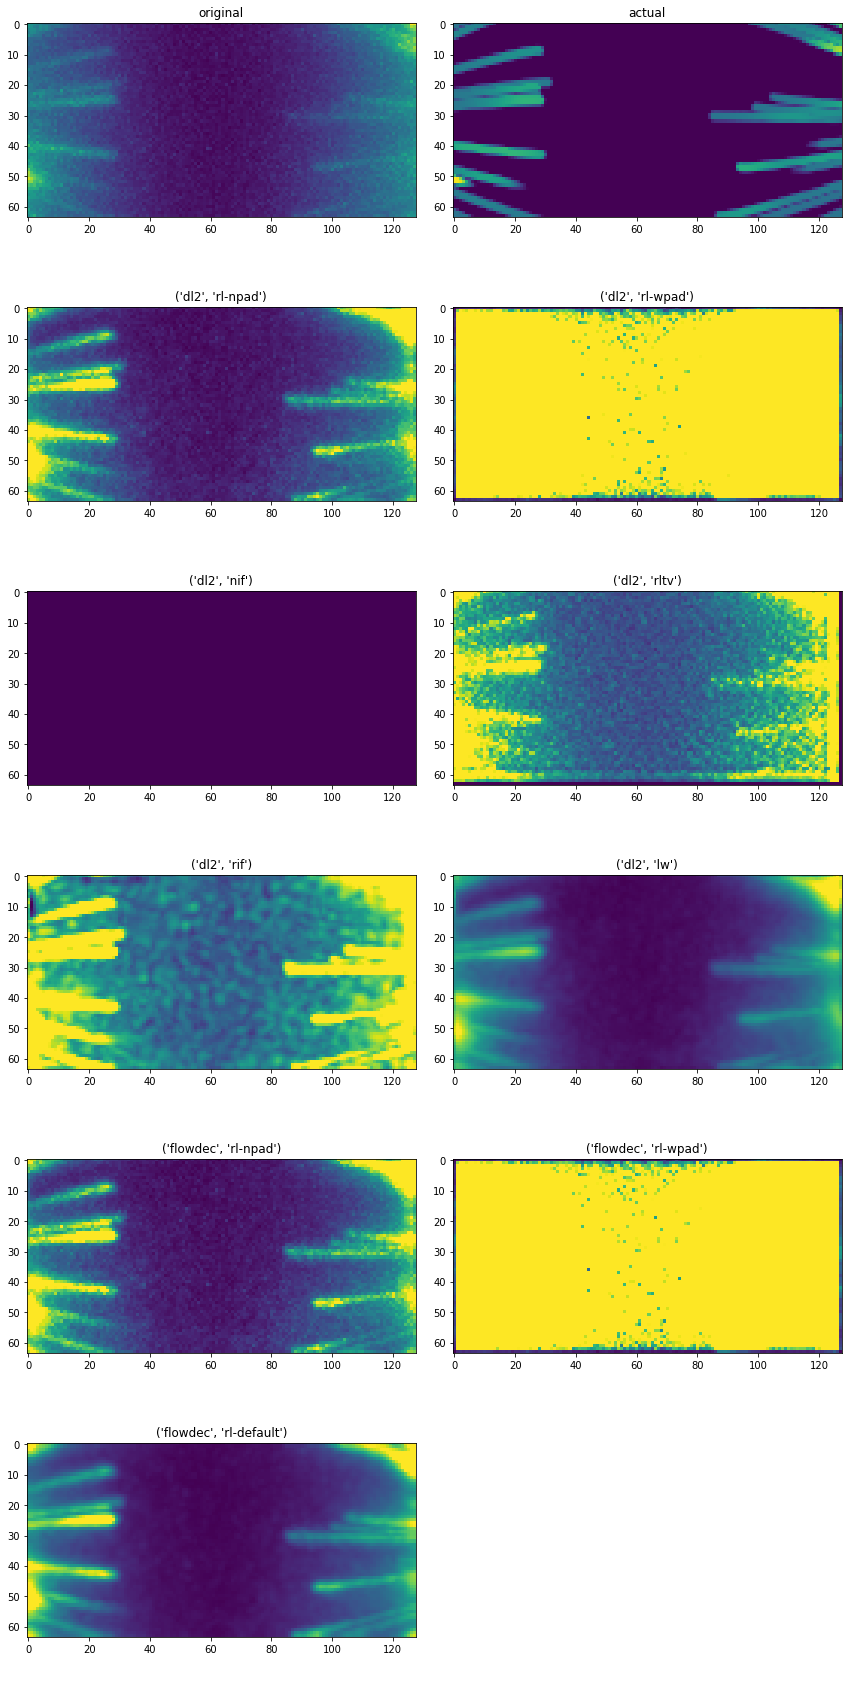

In [18]:
imgs = [('original', acq.data)]
if acq.actual is not None:
    imgs += [('actual', acq.actual)]
imgs += [(k, img) for k, img in acq_decon.items()]

ncols = 2
nrows = math.ceil(len(imgs) / ncols)
fig, axs = plt.subplots(nrows, ncols)
fig.set_size_inches(ncols * 6, nrows * 4)
axs = axs.ravel()
for ax in axs:
    ax.axis('off')
for i, (k, img) in enumerate(imgs):
    axs[i].imshow(img.max(axis=0))
    axs[i].set_title(k)
    axs[i].axis('on')
plt.tight_layout()

In [19]:
score_fns = dict(
    # Increase ssim window size to avoid obvious corner case w/ nearly completely saturated results
    ssim=lambda it, ip: compare_ssim(it, ip, win_size=31),
    
    # Use negative nrmse so that larger scores are better
    nrmse=lambda it, ip: -compare_nrmse(it, ip),
    
    psnr=compare_psnr
)

if acq.actual is not None:
    comp_type = 'ground_truth'
    img_true = acq.actual
else:
    comp_type = 'original'
    img_true = acq.data

def get_scores(img_pred):
    return {k:fn(img_true, img_pred) for k, fn in score_fns.items()}

scores = pd.DataFrame(
    {k: get_scores(img) for k, img in acq_decon.items()}
).T
scores.index.names = ['lib', 'algo']
scores = scores.reset_index().assign(comp_type=comp_type)
scores

,lib,algo,nrmse,psnr,ssim,comp_type
0,dl2,lw,-4.909214,11.752636,0.019556,ground_truth
1,dl2,nif,-13.056748,3.256175,0.000187,ground_truth
2,dl2,rif,-6.187815,9.742129,0.008926,ground_truth
3,dl2,rl-npad,-4.951842,11.677541,0.020552,ground_truth
4,dl2,rl-wpad,-5.902795,10.151721,0.001774,ground_truth
5,dl2,rltv,-5.563132,10.666488,0.010021,ground_truth
6,flowdec,rl-default,-4.865882,11.829645,0.022839,ground_truth
7,flowdec,rl-npad,-4.956679,11.669060,0.020536,ground_truth
8,flowdec,rl-wpad,-5.850576,10.228903,0.001787,ground_truth


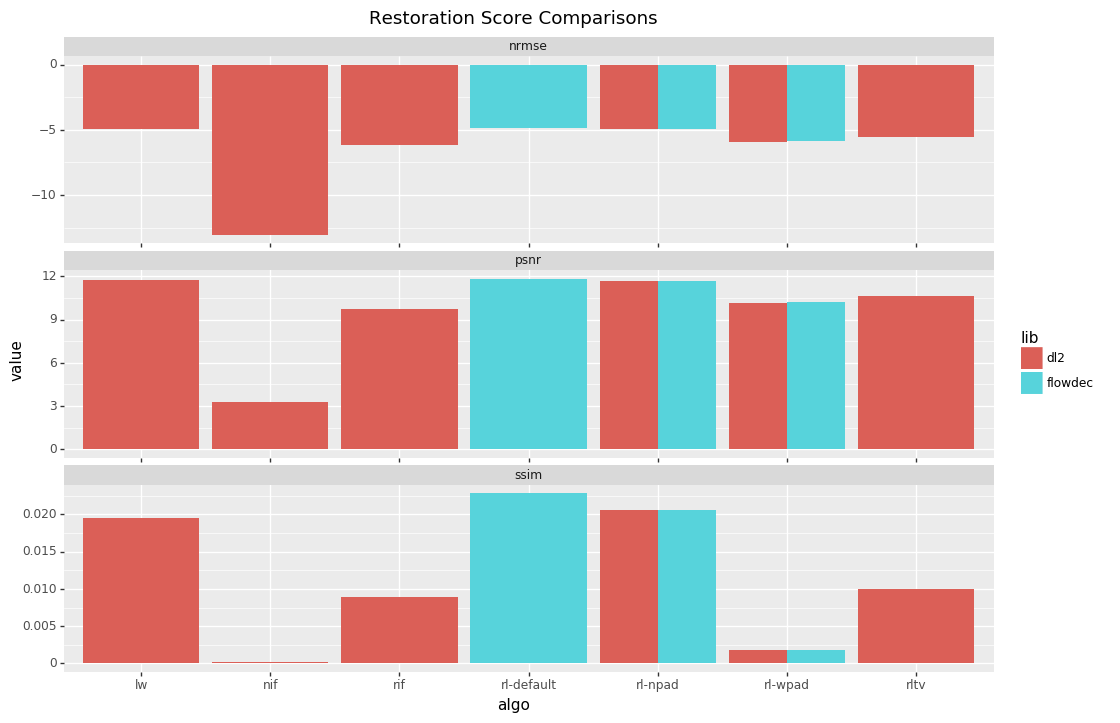

<ggplot: (153927545387)>

In [20]:
(
    pn.ggplot(
        scores.melt(id_vars=['lib', 'algo', 'comp_type']), 
        pn.aes(x='algo', y='value', fill='lib')
    ) +
    pn.geom_bar(stat='identity', position='dodge') +
    pn.facet_wrap('~variable', ncol=1, scales='free') +
    pn.ggtitle('Restoration Score Comparisons') +
    pn.theme(figure_size=(12, 8))
)

<hr>
### Export

In [21]:
buf = pyio.StringIO()
scores.to_json(buf, orient='records')
pm.record('scores', buf.getvalue())